# Twitter Sentiment Analysis.

## Business Problem.

We want to analyze a COVID-19 Twitter dataset to understand how positive and negative trends spread after news announcements.

Key Questions:

How do positive and negative sentiments spread among users after a news announcement related to COVID-19?

Purpose:

Help media outlets measure the impact of their announcements on public sentiment.

Goals:

Track sentiment trends over time.


## Dataset location and download instructions.

[Covid-19 Twitter Dataset](https://www.kaggle.com/datasets/arunavakrchakraborty/covid19-twitter-dataset/data)


* Place datasets into ```Data``` folder if running the notebook locally.
* Upload the files into ```/content``` root file folder of Colab environment.

## Installing the required modules.

We'll start with installing the requirements [available here](https://github.com/leksea/capstone-twitter-sentiment-analysis/blob/main/requirements.txt).

In [62]:
!wget https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
!pip install -r 'requirements.txt'

--2024-12-27 22:45:17--  https://raw.githubusercontent.com/leksea/capstone-twitter-sentiment-analysis/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     114  --.-KB/s    in 0s      

2024-12-27 22:45:17 (6.08 MB/s) - ‘requirements.txt’ saved [114/114]



### Importing modules.

In [63]:
# built-in modules
import os
import string
import re
import glob
import time
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
# url processing for extracting the coordinates
import requests
# progress bar monitoring
from tqdm import tqdm
# data manupulation, analysis
import numpy as np
import pandas as pd
# general data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# world maps
from folium import plugins
from folium.plugins import HeatMap
import branca.colormap as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#for location standartization
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# world cloud
from wordcloud import WordCloud
# Natural Language Processing (NLP)
import nltk
from emot.emo_unicode import UNICODE_EMOJI
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
%matplotlib inline
# stop words for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Supplemental Functions Will be Defined Here.

* Data loading

In [64]:
# Supplemental function to determine data directory
# Input: none
# Output: Data directory, depending on runtime environment.

def determine_data_dir():
    """
    Determines the data directory based on the execution environment:
    - Local: Uses 'Data' directory in the current working directory.
    - Cloud (e.g., Google Colab): Uses '/content' as the data directory.

    Returns:
        str: Path to the appropriate data directory.
    """
    if 'COLAB_GPU' in os.environ:  # Check if running in Google Colab
        data_dir = "/content"
        print(f"Running in Google Colab. Using data directory: {data_dir}")
    else:
        data_dir = os.path.join(os.getcwd(), "Data")
        print(f"Running locally. Using data directory: {data_dir}")

        # Ensure the 'Data' directory exists locally
        if not os.path.isdir(data_dir):
            print(f"The directory '{data_dir}' does not exist. Please create it and place the data files there.")
            raise FileNotFoundError(f"'{data_dir}' directory is required for local execution.")

    return data_dir

In [ ]:
# Supplemental function will display unique values for all categorical columns in a dataframe.
def display_categorical_vals(df):
    # select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # print categorical columns and their unique values
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"Column '{col}' has unique values: {unique_values}")

In [ ]:
# define a function to check for special characters
def has_special_chars(location):
    return bool(re.search(r'[^\w\s,.-]', location))  # check for non-alphanumeric and non-space chars

In [ ]:
# Initialize geolocator globally
geolocator = Nominatim(user_agent="batch-geocoding")

# Dictionary to cache geocoding results
location_cache = {}
# Supplemental function to use a geocoding API for location resolution
def geocode_location(location):
    """
    Resolve location using a geocoding API with caching.
    Returns results in City, State, Country format.
    """
    # Check cache first
    if location in location_cache:
        return location_cache[location]

    try:
        geo = geolocator.geocode(location, timeout=5)
        if geo:
            # Default: Extract the address components
            address = geo.raw.get('address', {})
            city = address.get('city') or address.get('town') or address.get('village') or address.get('hamlet')
            state = address.get('state')
            country = address.get('country')

            # Fallback: Parse city and country from display_name if missing
            if not city:
                try:
                    city = geo.raw['display_name'].split(',')[0].strip()
                except (KeyError, IndexError):
                    city = "Unknown"
            if not country:
                try:
                    country = geo.raw['display_name'].split(',')[-1].strip()
                except (KeyError, IndexError):
                    country = "Unknown"
            # Fallback: Parse state dynamically from display_name if missing or ambiguous
            if not state:
                try:
                    components = geo.raw['display_name'].split(',')
                    components = [comp.strip() for comp in components]
                    for i in range(len(components) - 1, -1, -1):  # Iterate backwards
                        if 'County' not in components[i] and "United States" not in components[i]:
                            state = components[i]
                            break
                except (KeyError, IndexError):
                    state = "Unknown"

            # Avoid redundancy: "Country, Unknown, Country"
            if city == country:
                city = "Unknown"
            if state == country:
                state = "Unknown"

            # Construct the result in the desired format
            result = f"{city}, {state}, {country}"
        else:
            result = "Unknown"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        result = f"Error: {e}"

    # Cache the result
    location_cache[location] = result
    return result

In [ ]:
# geocode multiple locations in parallel using ThreadPoolExecutor
def batch_geocode(locations):
    """
    Geocode multiple locations in parallel using ThreadPoolExecutor.
    """
    results = []
    with ThreadPoolExecutor(max_workers=5) as executor:  # max_workers can be adjusted as needed
        # Use tqdm to wrap the executor's map method for progress tracking
        for result in tqdm(executor.map(geocode_location, locations), \
                           total=len(locations), desc="Geocoding Progress"):
            results.append(result)
    return results

In [ ]:
# function to extract the first or last word from a location string
def extract_word(location, position="first"):
    """
    Extract the first or last word from a location string.

    Args:
        location (str): The location string to process.
        position (str): 'first' to extract the first word, 'last' to extract the last word.

    Returns:
        str: The extracted word or 'Unknown' if the location is empty or invalid.
    """
    words = location.split()
    if words:
        return words[0] if position == "first" else words[-1]
    return "Unknown"

In [ ]:
# function to split geocoded_location into City, State, and Country
def split_geocoded_location(location):
    if pd.notna(location):
        parts = location.split(",")
        parts = [p.strip() for p in parts]  # remove extra whitespace
        city = parts[0] if len(parts) > 0 else "Unknown"
        state = parts[1] if len(parts) > 1 else "Unknown"
        country = parts[2] if len(parts) > 2 else "Unknown"
        return city, state, country
    return "Unknown", "Unknown", "Unknown"

In [ ]:
def get_coordinates(input_type, name, output_as='center'):
    """
    Function to get coordinates of a country, state, or city using OpenStreetMap's Nominatim API.

    Args:
        input_type (str): Pass 'country', 'state', or 'city' to specify the type of input.
        name (str): Name of the country, state, or city for which to fetch coordinates.
        output_as (str): Specify 'center' for the central coordinates or 'boundingbox' for a bounding box.

    Returns:
        list: Latitude and Longitude as [lat, lon]. Returns [0, 0] if the location is not found.
    """
    # Create URL
    url = f'http://nominatim.openstreetmap.org/search?{input_type}={name}&format=json&polygon=0'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses
        data = response.json()
        if data:
            if output_as == 'center':
                return [float(data[0]['lat']), float(data[0]['lon'])]
            elif output_as == 'boundingbox':
                return [float(coord) for coord in data[0]['boundingbox']]
    except (IndexError, ValueError, KeyError, requests.RequestException) as e:
        print(f"Error fetching coordinates for {name}: {e}")
        return [0, 0]

In [ ]:
def add_coordinates(df, city_col='City', state_col='State', country_col='Country'):
    """
    Add latitude and longitude coordinates to a DataFrame based on City, State, and Country.

    Args:
        df (pd.DataFrame): The input DataFrame.
        city_col (str): Column name for city.
        state_col (str): Column name for state.
        country_col (str): Column name for country.

    Returns:
        pd.DataFrame: The updated DataFrame with 'Latitude' and 'Longitude' columns.
    """
    def fetch_coords(row):
        # prioritize City and State if available, otherwise fallback to Country
        if row[state_col] != 'Unknown' and row[country_col] != 'Unknown':
            location_name = f"{row[city_col]}, {row[state_col]}, {row[country_col]}"
            coords = get_coordinates('city', location_name)
        elif row[country_col] != 'Unknown':
            coords = get_coordinates('country', row[country_col])
        else:
            coords = [0, 0]  # Default to [0, 0] if both State and Country are 'Unknown'
        return coords

    # apply the fetch_coords function and split into Latitude and Longitude
    df[['Latitude', 'Longitude']] = df.apply(fetch_coords, axis=1, result_type='expand')
    return df

In [ ]:
# Function to determine marker color based on tweet count
def color(magnitude):
    if magnitude >= 2000:
        return 'red'
    elif 500 <= magnitude < 2000:
        return 'beige'
    else:
        return 'green'

# Function to generate the heatmap
def generateBaseMap(input_type, df, default_location=[40.693943, -73.985880], default_zoom_start=2):
    """
    Function to generate a heatmap with markers for tweet distribution.

    Args:
        input_type (str): 'country' or 'city' to specify the type of heatmap.
        df (pd.DataFrame): DataFrame containing latitude, longitude, tweet count, and name.
        default_location (list): Default map center location as [latitude, longitude].
        default_zoom_start (int): Default zoom level for the map.

    Returns:
        folium.Map: A folium map object with heatmap and markers.
    """
    # Initialize the base map
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    marker_cluster = plugins.MarkerCluster().add_to(base_map)

    # Add the heatmap
    HeatMap(data=df[['lat', 'long']].values.tolist(), radius=20, max_zoom=13).add_to(base_map)

    # Add markers with popups
    for lat, lon, tweet_count, name in zip(df['lat'], df['long'], df['# of tweets'], df.iloc[:, 0]):
        popup_content = folium.Popup(f"{name}<br>{tweet_count} tweets", max_width=300)
        folium.Marker(
            location=[lat, lon],
            popup=popup_content,
            icon=folium.Icon(color=color(tweet_count), icon='twitter', prefix='fa')
        ).add_to(marker_cluster)

    # Add a colormap legend
    min_val, max_val = df['# of tweets'].min(), df['# of tweets'].max()
    colormap = cm.LinearColormap(colors=['green', 'beige', 'red'], vmin=min_val, vmax=max_val)
    colormap.caption = f"{input_type.title()} Distribution of COVID-19 Tweets"
    colormap.add_to(base_map)

    return base_map

In [ ]:
# function to extract readable source from HTML content
def extract_source(source_text):
    """
    Extracts the readable text (e.g., 'Twitter for Android') from the source HTML string.

    Args:
        source_text (str): The raw HTML string in the source column.

    Returns:
        str: The cleaned, readable source text.
    """
    return re.sub(r'<.*?>', '', str(source_text)).strip()  # remove HTML tags

In [ ]:
# big cleaning function
def process_tweet_data(tweet, emoji_list=None):
    """
    Processes a tweet to extract mentions, hashtags, retweets, emojis, hyperlinks, and cleaned text.

    Args:
        tweet (str): The raw tweet text.
        emoji_list (list): List of emojis to extract. Defaults to keys of UNICODE_EMOJI.

    Returns:
        dict: Dictionary with extracted components and cleaned text.
    """
    # ensure input is a string
    tweet = str(tweet)

    # default emoji list if not provided
    if emoji_list is None:
        emoji_list = list(UNICODE_EMOJI.keys())

    # extract mentions
    mentions = re.findall(r'@\w+', tweet)

    # extract hashtags
    hashtags = re.findall(r'#\w+', tweet)

    # check for retweets and extract username after RT
    retweets = re.findall(r'^RT @(\w+)', tweet)
    retweet_user = retweets[0] if retweets else None

    # extract emojis
    emojis = ''.join([char for char in tweet if char in emoji_list])

    # extract hyperlinks
    hyperlinks = re.findall(r'https?://\S+|www\.\S+', tweet)

    # remove mentions, hashtags, retweets, emojis, and hyperlinks from the tweet
    cleaned_text = tweet
    cleaned_text = re.sub(r'@\w+', '', cleaned_text)  # Remove mentions
    cleaned_text = re.sub(r'#\w+', '', cleaned_text)  # Remove hashtags
    cleaned_text = re.sub(r'^RT', '', cleaned_text)   # Remove retweets
    cleaned_text = ''.join([char for char in cleaned_text if char not in emoji_list])  # Remove emojis
    cleaned_text = re.sub(r'https?://\S+|www\.\S+', '', cleaned_text)  # Remove hyperlinks

    # remove special characters, extra spaces, numbers
    cleaned_text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    cleaned_text = re.sub(r'\d+', '', cleaned_text)

    #lowercase the text, remove numbers
    cleaned_text = cleaned_text.lower()
    return {
        'mentions': mentions,
        'hashtags': hashtags,
        'retweets': retweets,
        'emojis': emojis,
        'hyperlinks': hyperlinks,
        'cleaned_text': cleaned_text
    }

In [ ]:
# progress wrapper for tweet cleaning
tqdm.pandas()

# function to process the entire DataFrame with progress tracking
def clean_tweets_with_progress(df, text_col='tweet_text'):
    """
    Cleans tweet data in the specified column and adds extracted components as new columns.

    Args:
        df (pd.DataFrame): DataFrame containing tweets.
        text_col (str): Column name containing the tweet text.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns for cleaned text and extracted components.
    """
    # Apply the cleaning function with a progress bar
    processed_data = df[text_col].progress_apply(process_tweet_data)

    # Expand the processed data dictionary into separate columns
    extracted_columns = pd.DataFrame(processed_data.tolist())
    return pd.concat([df, extracted_columns], axis=1)


## Loading The Covid-19 Twitter Datasets.

We're working with multiple CSV files.

In [65]:
## Loading the files
# determine the data directory
data_dir = determine_data_dir()

# locate all CSV files in the determined directory
files_pattern = os.path.join(data_dir, "*.csv")
files = glob.glob(files_pattern)

# check if files are found
if not files:
    print(f"No CSV files found in directory: {data_dir}")
else:
     # load and inspect each file
    dfs = []  # to store valid DataFrames
    for file in files:
        try:
            # load the DataFrame
            df = pd.read_csv(file)
            rows, cols = df.shape
            print(f"File: {file} | Rows: {rows}, Columns: {cols}")

            # skip empty files or files with no columns
            if rows == 0 or cols == 0:
                print(f"Skipping empty or invalid file: {file}")
                continue

            # append to list if valid
            dfs.append(df)

        except Exception as e:
            print(f"Error loading file {file}: {e}")

    # concatenate all valid DataFrames
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        print(f"Data loaded successfully with {data.shape[0]} rows and {data.shape[1]} columns.")
        print(data.head())
    else:
        print("No valid DataFrames to concatenate.")

Running in Google Colab. Using data directory: /content
File: /content/Covid-19 Twitter Dataset (Aug-Sep 2020).csv | Rows: 120509, Columns: 17
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2020).csv | Rows: 143903, Columns: 17
File: /content/Covid-19 Twitter Dataset (Apr-Jun 2021).csv | Rows: 147475, Columns: 17
Data loaded successfully with 411887 rows and 17 columns.
             id  created_at  \
0  1.300000e+18  2020-08-20   
1  1.300000e+18  2020-08-20   
2  1.300000e+18  2020-08-20   
3  1.300000e+18  2020-08-20   
4  1.300000e+18  2020-08-20   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="https://about.twitter.com/products/tw...   
4  <a href="http://twitter.com/download/android" ...   

                                       original_text lang  favorite_count  \
0  RT @RobertAlai: 91-ye

## Exploratory Data Analysis.
### Data Understanding and Cleaning.

We'll start with getting general information about the dataset and identify the columns of interest.

In [66]:
# get general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411887 entries, 0 to 411886
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               411883 non-null  float64
 1   created_at       411885 non-null  object 
 2   source           411587 non-null  object 
 3   original_text    411885 non-null  object 
 4   lang             411884 non-null  object 
 5   favorite_count   411884 non-null  float64
 6   retweet_count    411884 non-null  float64
 7   original_author  411884 non-null  object 
 8   hashtags         97775 non-null   object 
 9   user_mentions    295207 non-null  object 
 10  place            293775 non-null  object 
 11  clean_tweet      409915 non-null  object 
 12  compound         411887 non-null  float64
 13  neg              411887 non-null  float64
 14  neu              411887 non-null  float64
 15  pos              411887 non-null  float64
 16  sentiment        411887 non-null  obje

In [67]:
# info about the numeric columns
data.describe()

,id,favorite_count,retweet_count,compound,neg,neu,pos
count,4.118830e+05,411884.000000,411884.000000,411887.000000,411887.000000,411887.000000,411887.000000
mean,1.324197e+18,0.216726,1585.174163,0.008415,0.090920,0.807021,0.102052
std,5.902218e+16,6.332250,9423.896052,0.370853,0.152717,0.200474,0.157080
min,1.250000e+18,0.000000,0.000000,-0.992500,0.000000,0.000000,0.000000
25%,1.260000e+18,0.000000,1.000000,-0.102700,0.000000,0.667000,0.000000
50%,1.310000e+18,0.000000,15.000000,0.000000,0.000000,0.819000,0.000000
75%,1.395011e+18,0.000000,243.000000,0.226300,0.180000,1.000000,0.200000
max,1.409140e+18,2923.000000,416923.000000,0.980500,1.000000,1.000000,1.000000


In [116]:
# select subset of tweets we'll be working with:
cols_to_keep = ['id', 'created_at', 'original_text', \
                'lang', 'favorite_count', 'retweet_count', 'original_author', \
                'hashtags', 'user_mentions', 'place', 'neg', 'neu', 'pos']
tweets_df = data[cols_to_keep].copy()

In [118]:
display_categorical_vals(tweets_df)

Column 'created_at' has unique values: ['2020-08-20' '2020-08-21' '2020-08-22' '2020-08-23' '2020-08-24'
 '2020-08-26' '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31'
 '2020-09-01' '2020-09-02' '2020-09-03' '2020-09-06' '2020-09-12'
 '2020-09-13' '2020-09-15' '2020-09-17' '2020-09-19' '2020-09-20'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' nan '2020-10-05' '2020-10-06'
 '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-10' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-20' '2020-04-19'
 '2020-04-22' '2020-04-23' '2020-04-24' '2020-04-25' '2020-04-26'
 '2020-04-27' '2020-04-28' '2020-04-29' '2020-04-30' '2020-05-01'
 '2020-05-02' '2020-05-03' '2020-05-04' '2020-05-05' '2020-05-06'
 '2020-05-07' '2020-05-08' '2020-05-09' '2020-05-10' '2020-05-11'
 '2020-05-12' '2020-05-13' '2020-

### Data Type Conversion.

In [119]:
#rename date column for clarity and convert to date
tweet_df = data.rename(columns={'created_at': 'date'})
tweet_df['date'] = pd.to_datetime(tweet_df['date'])

Follow by exploratory data analysis:
* What were daily tweet patters?
* What were the top 20 days with most tweets?  

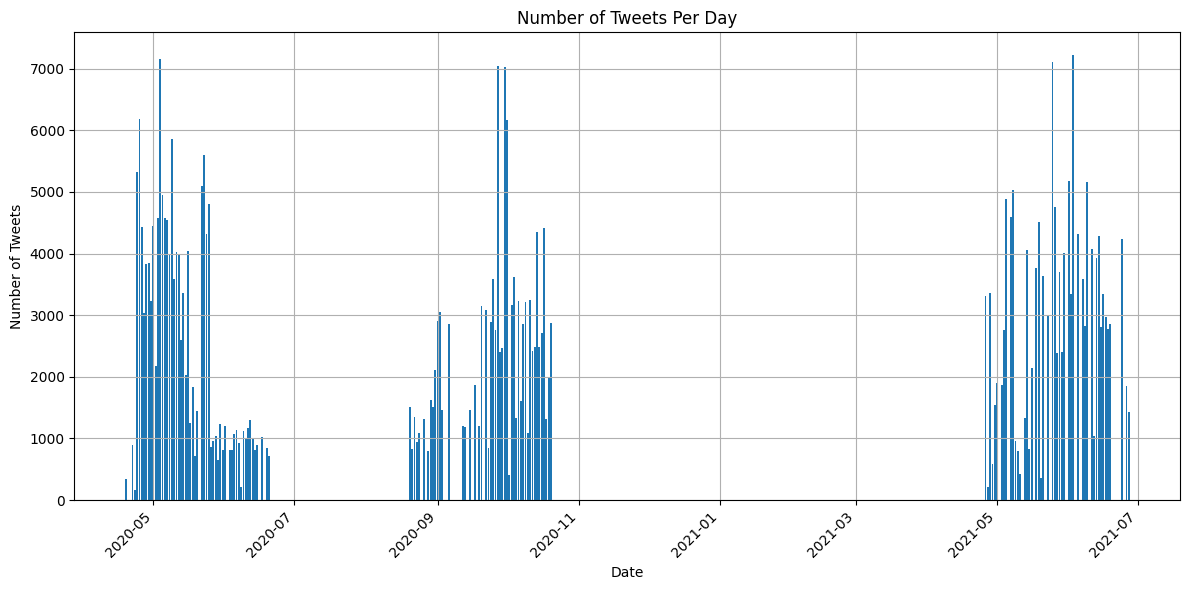

In [120]:
# exploratory analysis: plot number of tweets per day
# group by date and count tweets
tweets_per_day = tweet_df.groupby(tweet_df['date'].dt.date)['id'].count()

plt.figure(figsize=(12, 6))
plt.bar(tweets_per_day.index, tweets_per_day.values)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets Per Day")
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [121]:
# exploratory analysis: list the top 20 days with the most tweets
# rename columns for clarity
tweets_per_day.columns = ['date', 'tweet_count']

# sort by tweet count and get the top 20
top_20_days = tweets_per_day.sort_values(ascending=False).head(20)

# display the result
print(top_20_days)

date
2021-06-03    7229
2020-05-04    7165
2021-05-25    7114
2020-09-27    7040
2020-09-30    7028
2020-04-25    6178
2020-10-01    6166
2020-05-09    5857
2020-05-23    5600
2020-04-24    5323
2021-06-01    5175
2021-06-09    5158
2020-05-22    5102
2021-05-08    5032
2020-05-05    4949
2021-05-05    4886
2020-05-25    4804
2021-05-26    4750
2021-05-07    4586
2020-05-06    4575
Name: id, dtype: int64


### Evaluating and Handling Missing Values.
Before coming up with the strategy for each column, we'll check the contents of categorical data and the distributiuon of NaNs.

* It would make sence that fields like ```hashtags``` and ```user_mentions``` would have missing values and we'll leave it as it is.
* We'll check the ```lang``` and ```place``` columns.


In [122]:
# number of NaNs in lang
sum(tweet_df.lang.isna())

3

In [123]:
# look at the tweet text
tweet_df[tweet_df.lang.isna()]

,id,date,source,original_text,lang,favorite_count,retweet_count,original_author,hashtags,user_mentions,place,clean_tweet,compound,neg,neu,pos,sentiment
77157,1.310000e+18,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.0,neu
143634,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000,1.000,0.0,neu
357288,1.400490e+18,2021-06-03,"<a href=""http://twitter.com/download/android"" ...",@santoshmt7666 @globaltimesnews The COVID-19 d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,covid19 death toll india could time higher,-0.5994,0.394,0.606,0.0,neg


The only 3 rows where language is missing are missing the original text, so we'll discard them.

In [124]:
# drop rows where 'lang' is NaN
tweet_df = tweet_df.dropna(subset=['lang'])

# verify the changes
print(f"Number of NaNs in 'lang' after dropping: {sum(tweet_df.lang.isna())}")

# drop the lang column from the df
tweet_df.drop(columns=['lang'], inplace=True)

Number of NaNs in 'lang' after dropping: 0


<ipython-input-124-2992a6e36ebc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df.drop(columns=['lang'], inplace=True)


In [125]:
#rename place column to location for clarity
tweet_df = tweet_df.rename(columns={'place': 'location'})

In [126]:
# count of NaNs
sum(tweet_df.location.isna())

118109

In [127]:
# fill location NaNs with Unknown
tweet_df.fillna(value={'location':'Unknown'}, inplace=True)

### Data Cleaning.

Here we'll see if location can be cleaned up for further visualization. We'll start with checking the locations with at least 10 tweets.  

In [128]:
# calculate value counts for the 'location' column
location_counts = tweet_df.location.value_counts()

# filter to keep locations with at least 20 occurrences
filtered_locations = location_counts[location_counts >= 10]

# fisplay the filtered results
print(filtered_locations)

location
Unknown                    118146
United States                4539
India                        4283
London                       2646
London, England              2638
                            ...  
Republic of Korea              10
Whitby, Ontario, Canada        10
Appleton, WI                   10
Malmo, Sweden                  10
Dhanbad, India                 10
Name: count, Length: 2748, dtype: int64


Next, we'll check the locations with the special characters (non-alphanumeric that are not the ```-,.```).

In [129]:
# apply the function to create a boolean mask
special_chars_mask = tweet_df['location'].apply(has_special_chars)

# filter the DataFrame and get value counts
locations_with_special_chars = tweet_df.loc[special_chars_mask, 'location'].value_counts()

# display the result
print(locations_with_special_chars)

location
भारत                              211
കേരളം                             155
नई दिल्ली, भारत                    87
she/her                            81
मुंबई, भारत                        80
                                 ... 
God’s Country....                   1
Oakville/Liberty Village/FMTY✈      1
Photo : Blue Mountains              1
#ConstitutionalSweatEquity 🗽        1
USA  🇺🇲                             1
Name: count, Length: 16221, dtype: int64


 We'll try to salvage the locations by using the first or the last word in a multi-word location. Otherwise, set it to the 'Unknown'.

In [130]:
# create a boolean mask for one-word locations, those we won't be able to automatically ID
one_word_mask = locations_with_special_chars.index.str.split().str.len() == 1
one_word_locations = locations_with_special_chars[one_word_mask].index

# replace those locations in the original DataFrame with 'Unknown'
tweet_df['location'] = tweet_df['location'].replace(one_word_locations, 'Unknown')

The brief explanation for ```geocode_location()``` function:
* It utilizes the geocoding API. We give it a location (string), and it returns a best(first) guess for the location. For example, if I give it ```Paris```, it will return ```Paris, France``` and not ```Paris, Texas```.
* It executes slowly.

In [208]:
# test it on few entries
# Test the function
print(geocode_location('New York, NY'))                                       # Expected: "New York, New York, United States"
print(geocode_location('Toronto, Ontario'))                                   # Expected: "Toronto, Ontario, Canada"
print(geocode_location('India'))                                              # Expected: "Unknown, Unknown, India"
print(geocode_location('USA'))                                                # Expected: "Unknown, Unknown, United States"

City of New York, New York, United States
Toronto, Unknown, Canada
Unknown, Unknown, India
Unknown, None, United States
Permanent Mission of the United States to the United Nations, 10017, United States


Additionally, we implemented parallel optimization in ```batch_geocode()```.

In [190]:
# before applying, do minor cleaning: replace 'unknown' with 'Unknown'
tweet_df.location.replace('unknown', 'Unknown')

,location
0,"Nairobi, Kenya"
1,Unknown
2,Sidheart
3,"ÜT: 51.511924,-0.22414"
4,India
...,...
411882,Unknown
411883,"Airport Heights Campus, NUST."
411884,"Melbourne, Victoria, Australia"
411885,"Kampala, Uganda"


In [191]:
# calculate value counts for the 'location' column
location_counts = tweet_df.location.value_counts()

# filter to keep locations with at least 10 occurrences
filtered_locations = location_counts[location_counts >= 10]

# remove 'Unknown' from filtered_locations
filtered_locations_known = filtered_locations[filtered_locations.index != 'Unknown']

# create a boolean mask for locations in filtered_locations_known
mask = tweet_df['location'].isin(filtered_locations_known.index)

# get unique locations from the filtered DataFrame
unique_locations = tweet_df.loc[mask, 'location'].unique()

In [210]:
# apply geocode_location only to the selected locations in parallel
geocoded_results = dict(zip(unique_locations, batch_geocode(unique_locations)))

# map the results back to the DataFrame
tweet_df.loc[mask, 'geocoded_location'] = tweet_df.loc[mask, 'location'].map(geocoded_results)

Geocoding Progress: 100%|██████████| 2713/2713 [15:03<00:00,  3.00it/s]


In [211]:
# check value counts
tweet_df['geocoded_location'].value_counts()

,count
geocoded_location,
Unknown,234494
"Unknown, None, United States",7148
"London, Unknown, United Kingdom",6488
"Unknown, Unknown, India",4903
"City of New York, New York, United States",4287
...,...
"Panaji, Unknown, India",10
"Kilkenny, Unknown, Éire / Ireland",10
"Begusarai, Unknown, India",10


Continue location data cleaning. For all undecoded ```geocoded_location```, try to apply first then last words of ```location```.

In [228]:
# create a mask for rows where 'geocoded_location' is 'Unknown' and where its known
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'
known_mask = tweet_df['geocoded_location'] != 'Unknown'
# extract FIRST word from 'location' for 'Unknown' geocoded rows and batch process
if unknown_mask.any():
    first_words = tweet_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="first"))

    unique_first_words = first_words.unique()
    unique_first_words_set = set(unique_first_words)
    # extract known locations where geocoded_location is not 'Unknown'
    known_locations = tweet_df.loc[known_mask, 'location']
    # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_first_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for matched first words
    first_word_results = batch_geocode(matched_words)
    # create a mapping of unique first words to geocoded results
    first_word_mapping = dict(zip(matched_words, first_word_results))

    # map the results back to the DataFrame
    tweet_df.loc[unknown_mask, 'geocoded_location'] = first_words.map(first_word_mapping)

Geocoding Progress: 100%|██████████| 1847/1847 [04:29<00:00,  6.85it/s]


In [230]:
# update the mask for remaining 'Unknown' rows
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'
known_mask = tweet_df['geocoded_location'] != 'Unknown'

# extract LAST word from 'location' for remaining 'Unknown' rows and batch process
if unknown_mask.any():
    last_words = tweet_df.loc[unknown_mask, 'location'].apply(lambda loc: extract_word(loc, position="last"))
    unique_last_words = last_words.unique()
    unique_last_words_set = set(last_words)

    known_locations = tweet_df.loc[known_mask, 'location']

     # tokenize each location into words and find intersection with unique_first_words_set
    known_words_in_locations = known_locations.str.split().apply(lambda words: unique_last_words_set.intersection(words))

    # extract matches
    matched_words = {word for words in known_words_in_locations for word in words}

    # perform geocoding for unique last words
    last_word_results = batch_geocode(matched_words)  # Ensure batch_geocode is defined
    # create a mapping of unique last words to geocoded results
    last_word_mapping = dict(zip(matched_words, last_word_results))

    # map the results back to the DataFrame
    tweet_df.loc[unknown_mask, 'geocoded_location'] = last_words.map(last_word_mapping)

Geocoding Progress: 100%|██████████| 57/57 [00:07<00:00,  7.89it/s]


In [231]:
# if still 'Unknown', give up
unknown_mask = tweet_df['geocoded_location'] == 'Unknown'
if unknown_mask.any():
    print(f"Giving up on {unknown_mask.sum()} locations. Could not geocode these entries.")

Giving up on 63 locations. Could not geocode these entries.


In [232]:
# fill location NaNs with Unknown
tweet_df.fillna(value={'geocoded_location':'Unknown'}, inplace=True)

Next, we'll use ```split_geocoded_location()``` to split the geocoded_location into three columns: ```Country```, ```State```, and ```City```.

In [234]:
# apply the function to create separate columns
tweet_df[['City', 'State', 'Country']] = tweet_df['geocoded_location'].apply(
    lambda loc: pd.Series(split_geocoded_location(loc))
)
# display the DataFrame with new columns
tweet_df[['geocoded_location', 'City', 'State', 'Country']]

,geocoded_location,City,State,Country
0,"Nairobi, Unknown, Kenya",Nairobi,Unknown,Kenya
1,"unknown, Unknown, India",unknown,Unknown,India
2,Unknown,Unknown,Unknown,Unknown
3,Unknown,Unknown,Unknown,Unknown
4,"Unknown, Unknown, India",Unknown,Unknown,India
...,...,...,...,...
411882,"unknown, Unknown, India",unknown,Unknown,India
411883,Unknown,Unknown,Unknown,Unknown
411884,"Melbourne, Unknown, Australia",Melbourne,Unknown,Australia
411885,"Kampala, Unknown, Uganda",Kampala,Unknown,Uganda


In [237]:
# minor fix: capitalization
# Capitalize all entries in 'City', 'State', and 'Country' columns
tweet_df['City'] = tweet_df['City'].str.title()
tweet_df['State'] = tweet_df['State'].str.title()
tweet_df['Country'] = tweet_df['Country'].str.title()

Location EDA: tweet histograms by Country (Worldwide), by City (Worldwide), By  State(US).

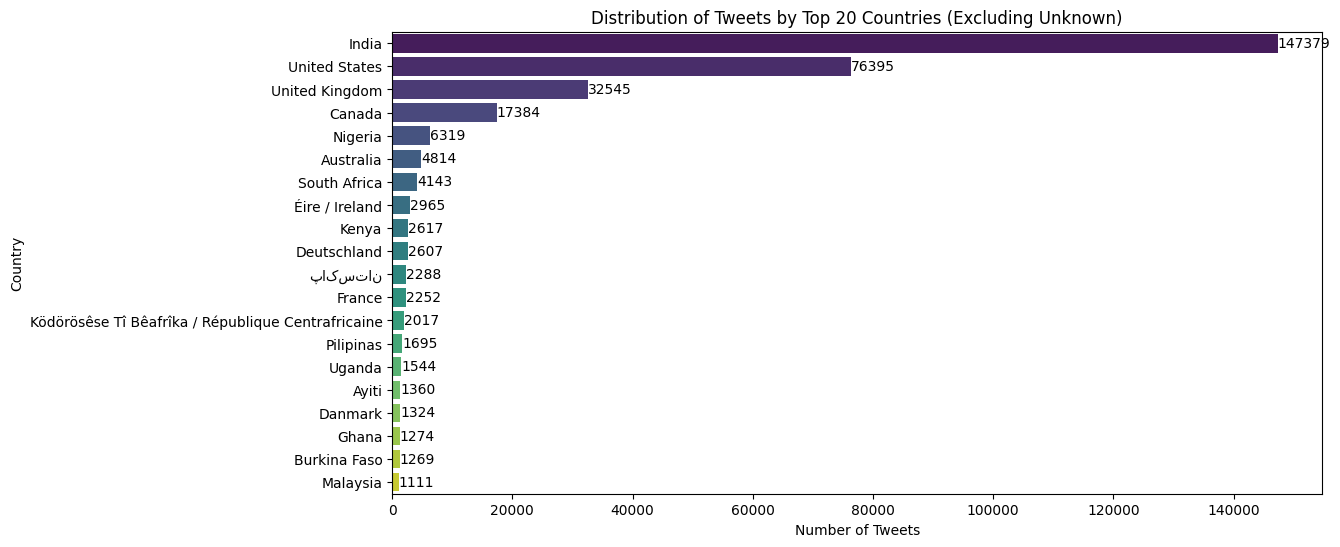

In [238]:
# 1. Country EDA: Remove 'Unknown' countries and plot histogram for top 20 (ordered)
known_countries = tweet_df[tweet_df['Country'] != 'Unknown']
top_20_countries = known_countries['Country'].value_counts().nlargest(20)

plt.figure(figsize=(12, 6))
sns.barplot(
    y=top_20_countries.index,
    x=top_20_countries.values,
    hue=top_20_countries.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 20 Countries (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('Country')
for i, v in enumerate(top_20_countries.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

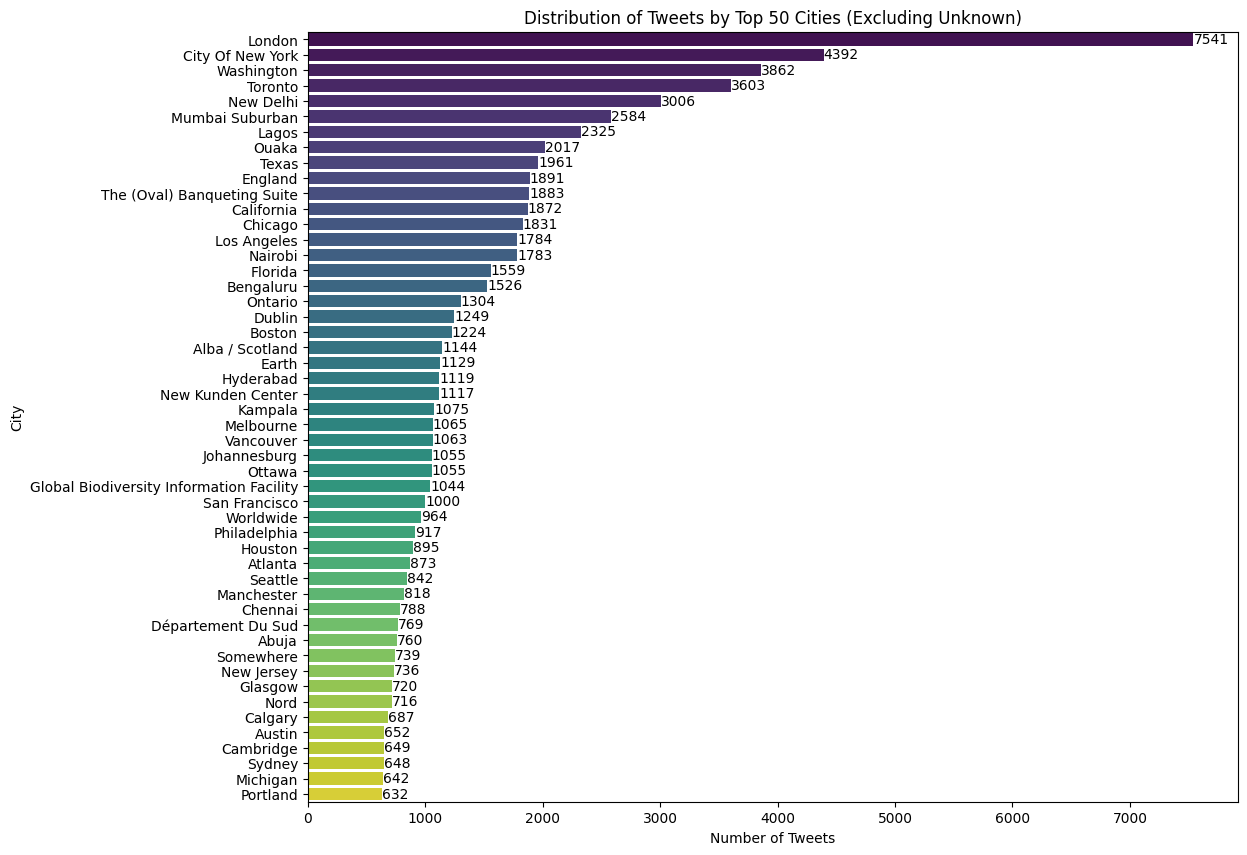

In [239]:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweet_df[tweet_df['City'] != 'Unknown']
top_50_cities = known_cities['City'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

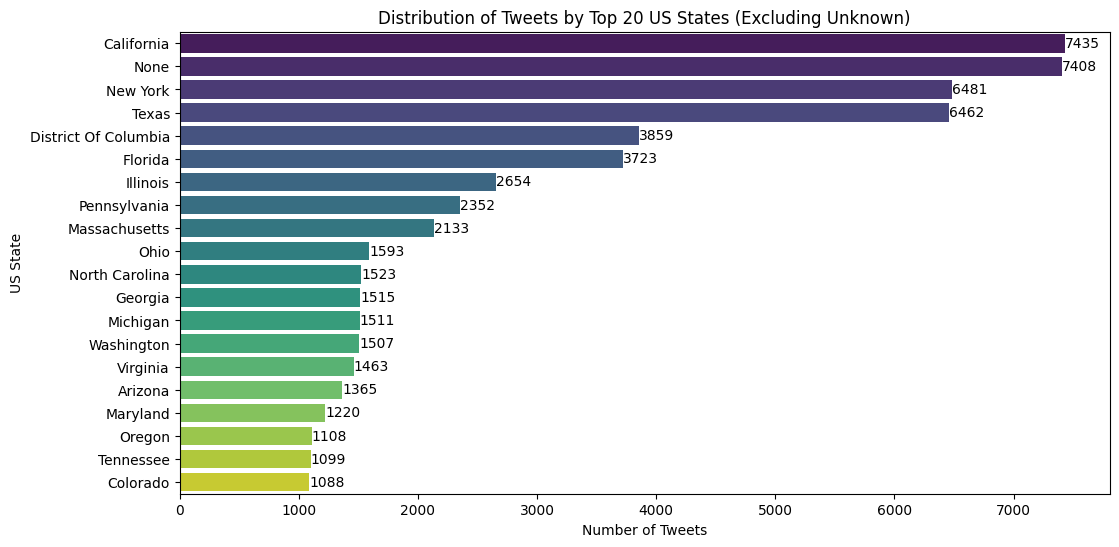

In [240]:
# Filter out 'Unknown' states and keep only US entries
us_states = tweet_df[(tweet_df['Country'] == 'United States') & (tweet_df['State'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['State'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

In [242]:
# minor fixes: Move Florida, California, Texas, Michigan  from City to State and rename None in state to Unknown
states_as_cities = ['Florida', 'California', 'Texas', 'Michigan']
mask_states_as_cities = (tweet_df['City'].isin(states_as_cities)) & (tweet_df['Country'] == 'United States')

# update State and City columns for these entries
tweet_df.loc[mask_states_as_cities, 'State'] = tweet_df.loc[mask_states_as_cities, 'City']
tweet_df.loc[mask_states_as_cities, 'City'] = 'Unknown'

# rename all 'None' in State to 'Unknown'
tweet_df['State'] = tweet_df['State'].replace('None', 'Unknown')

# fix "Alba/Scotland" entries
mask_alba_scotland = tweet_df['City'].str.contains('Alba/Scotland', case=False, na=False)

# update City and Country for Alba/Scotland
tweet_df.loc[mask_alba_scotland, 'City'] = 'Unknown'
tweet_df.loc[mask_alba_scotland, 'Country'] = 'Scotland'

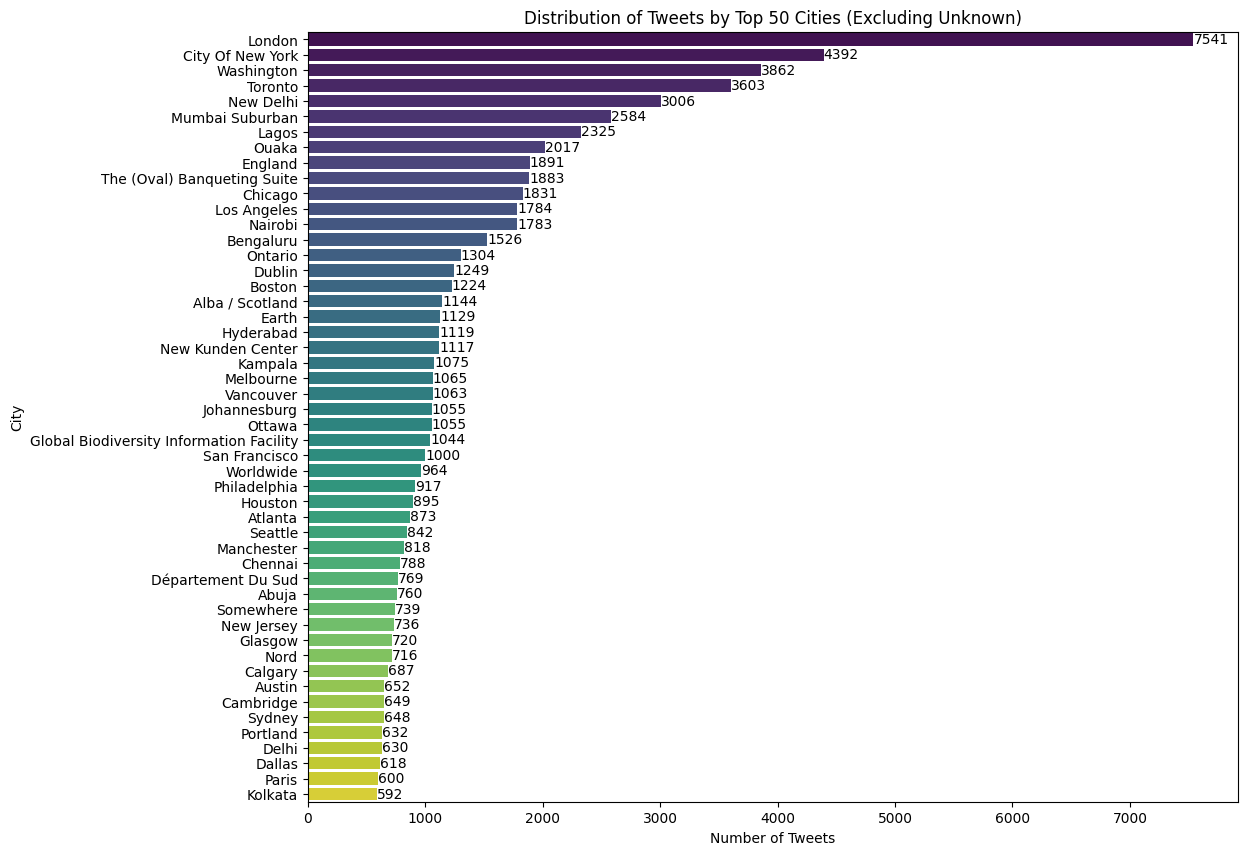

In [243]:
# redo the city plot:
# 2. Remove 'Unknown' cities and plot histogram for top 50 (ordered)
known_cities = tweet_df[tweet_df['City'] != 'Unknown']
top_50_cities = known_cities['City'].value_counts().nlargest(50)

plt.figure(figsize=(12, 10))
sns.barplot(
    y=top_50_cities.index,
    x=top_50_cities.values,
    hue=top_50_cities.index,  # Assign y to hue
    palette='viridis',
    dodge=False,  # Ensure no splitting
    legend=False  # Disable legend
)
plt.title('Distribution of Tweets by Top 50 Cities (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('City')
for i, v in enumerate(top_50_cities.values):
    plt.text(v, i, f"{v}", va='center')
plt.show()

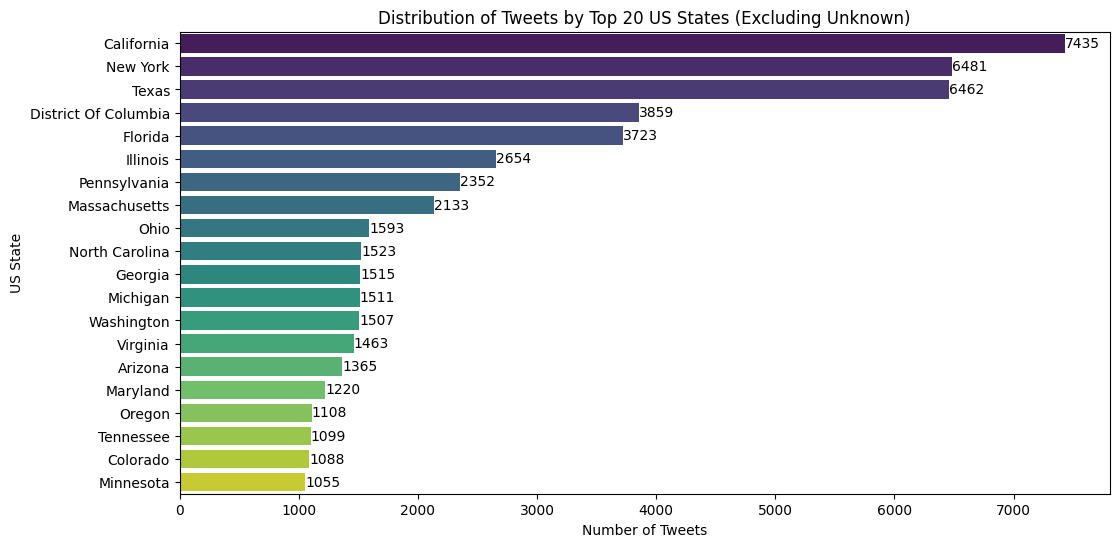

In [245]:
# redo the states plot:
# Filter out 'Unknown' states and keep only US entries
us_states = tweet_df[(tweet_df['Country'] == 'United States') & (tweet_df['State'] != 'Unknown')]

# Count occurrences of each state and get the top 20
state_counts = us_states['State'].value_counts().nlargest(20)

# Plot the distribution of tweets by the top 20 US states
plt.figure(figsize=(12, 6))
sns.barplot(
    y=state_counts.index,
    x=state_counts.values,
    hue=state_counts.index,  # Use state as hue
    palette='viridis',
    dodge=False,  # Prevent splitting bars
    legend=False  # Suppress the legend
)
plt.title('Distribution of Tweets by Top 20 US States (Excluding Unknown)')
plt.xlabel('Number of Tweets')
plt.ylabel('US State')

# Add labels to the bars
for i, v in enumerate(state_counts.values):
    plt.text(v, i, f"{v}", va='center')

plt.show()

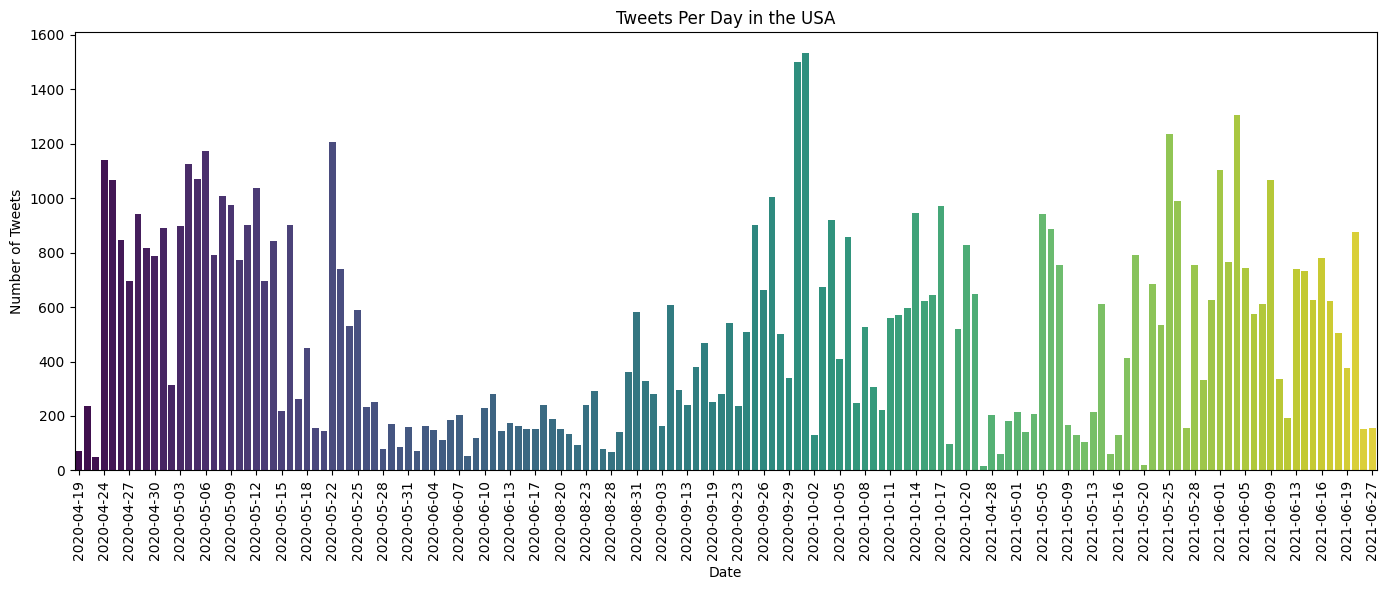

In [254]:
# USA tweets per day
usa_tweets = tweet_df[tweet_df['Country'] == 'United States']

# group by date and count tweets per day
tweets_per_day = usa_tweets.groupby(usa_tweets['date'].dt.date).size().reset_index(name='Total Tweets')
tweets_per_day.columns = ['Date', 'Total Tweets']

# bar plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=tweets_per_day,
    x='Date',
    y='Total Tweets',
    hue='Date',  # Assign the x variable to hue
    palette='viridis',
    legend=False  # Disable the legend
)

# customize x-axis ticks to show every third date
xticks = plt.gca().get_xticks()
xtick_labels = tweets_per_day['Date'].astype(str).values
plt.xticks(
    ticks=xticks[::3],  # show every third tick
    labels=xtick_labels[::3],  # use corresponding labels
    rotation=90  # rotate 45 deg for better visibility
)

plt.xticks(rotation=90)  # rotate x-axis labels for better readability
plt.title('Tweets Per Day in the USA')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

#TODO add lattitude, longitude
Add Folium map

In [ ]:
tweet_df = add_coordinates(tweet_df)

Next, we'll replace the ```source``` values with readable meaningful values using ```extract_source()``` function that will extract the value between the HTML tags.

In [262]:
# replace the source with the meaningful value
tweet_df.source.value_counts()

,count
source,
"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",122816
"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",106325
"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",106135
"<a href=""http://twitter.com/#!/download/ipad"" rel=""nofollow"">Twitter for iPad</a>",14598
"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",6839
...,...
"<a href=""https://iampunjab.co.in"" rel=""nofollow"">IAmPunjab Twitter</a>",1
"<a href=""http://www.socialpsychology.org/"" rel=""nofollow"">Social Psychology Network App</a>",1
"<a href=""https://www.facebook.com/reed.abend"" rel=""nofollow"">App_for_Reed</a>",1


In [270]:
# apply the function to the 'source' column
tweet_df['source'] = tweet_df['source'].apply(extract_source)
# identify sources with counts less than 100
source_counts = tweet_df['source'].value_counts()
low_count_sources = source_counts[source_counts < 100].index

# replace low-count sources with 'Other'
tweet_df['source'] = tweet_df['source'].replace(low_count_sources, 'Other')
tweet_df['source'].value_counts()

,count
source,
Twitter for Android,122816
Twitter Web App,106325
Twitter for iPhone,106135
Other,15342
Twitter for iPad,14598
...,...
PulpNews,102
Sentir Radio Nowplaying,102
Fabrik.fm,101


In [269]:
# plot the top 20 sources
top_20_sources = tweet_df['source'].value_counts().nlargest(20)

# Convert to a DataFrame for plotting
top_20_df = top_20_sources.reset_index()
top_20_df.columns = ['Source', 'Count']

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_20_df,
    y='Source',
    x='Count',
    palette='viridis'
)
plt.title('Top 20 Twitter Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

### Cleaning the original twitter texts.
We wrote ```process_tweet_data()```to do the following:
* Remove and store emoji as a separate column(using default UNICODE_EMOJI).
* Remove and store mentions @ as a separate column.
* Remove and store retweets RT @ as a separate column.
* Remove and store hashtags # as a separate column.
* Remove and store URLs www. or t. or bit. as a separate column.
* Remove special characters, whitespaces, numbers.
* Lowercase and store text in ```cleaned_text``` column  

In [278]:
tweet_slice_df = tweet_df[['id', 'date', 'source', 'original_text', 'original_author', 'favorite_count',    'retweet_count', \
                          'sentiment', 'City',  'State', 'Country']].copy()
# select a random sample of 20 entries
test_copy = tweet_slice_df.sample(n=20, random_state=42)  # Use random_state for reproducibility

# display the test_copy df
test_copy

,id,date,source,original_text,original_author,favorite_count,retweet_count,sentiment,City,State,Country
214199,1.260000e+18,2020-05-16,Twitter for iPhone,"RT @YehuMoran: 1/4 I'm terrified: Okay, so we ...",Andrewjohnaman,0.0,5480.0,pos,Charlottesville,Virginia,United States
301931,1.393227e+18,2021-05-14,Buffer,Security Agencies Leading by Example in Suppor...,zbconline,0.0,132.0,pos,Saint,Unknown,India
185213,1.260000e+18,2020-05-08,Twitter for Android,RT @GailYentaBeck: Mission accomplished @CFSno...,AlsFastball,0.0,52.0,pos,Toronto,Unknown,Canada
26610,1.310000e+18,2020-09-15,Twitter for Android,RT @ZeeNewsEnglish: PM Garib Kalyan Package In...,Kul_Swan,0.0,1.0,neg,Unknown,Unknown,Unknown
129285,1.250000e+18,2020-04-25,Twitter for iPhone,RT @YMCAEng_Wales: COVID-19 is frightening us ...,PoppyPB,0.0,2902.0,neg,Unknown,Unknown,Unknown
399299,1.405980e+18,2021-06-18,TweetDeck,"@devinmci devin, you can't prove anyone has di...",CDCarter13,0.0,0.0,neg,Online,Unknown,France
33961,1.310000e+18,2020-09-22,Twitter Web App,Several aspects of the world economy including...,FBNQuest,0.0,84.0,neu,Lagos,Unknown,Nigeria
153315,1.260000e+18,2020-05-01,Twitter for Android,RT @HFWOdisha: State Rapid Response Team led b...,Varsha__Panda,0.0,10612.0,pos,Unknown,Unknown,India
397308,1.405630e+18,2021-06-17,Twitter for iPad,"RT @danwe11ings: In the end, there was no stat...",Natalie93899450,0.0,0.0,neu,Virginia,Virginia,United States
129826,1.250000e+18,2020-04-25,Twitter for iPad,RT @Wardamn5: This should be NEWS! Why are [th...,val26534947,0.0,34.0,neu,Unknown,Unknown,India


In [277]:
# apply the function to test dataframeeach tweet and expand the results into separate columns
test_copy = pd.concat([
    test_copy,
    test_copy['original_text'].apply(lambda x: pd.Series(process_tweet_data(x)))
], axis=1)

test_copy.head()

,id,date,source,original_text,original_author,favorite_count,retweet_count,sentiment,City,State,...,retweets,emojis,hyperlinks,cleaned_text,mentions,hashtags,retweets,emojis,hyperlinks,cleaned_text
214199,1.260000e+18,2020-05-16,Twitter for iPhone,"RT @YehuMoran: 1/4 I'm terrified: Okay, so we ...",Andrewjohnaman,0.0,5480.0,pos,Charlottesville,Virginia,...,[YehuMoran],,[],im terrified okay so we had a journal club ye...,[@YehuMoran],[],[YehuMoran],,[],im terrified okay so we had a journal club ye...
301931,1.393227e+18,2021-05-14,Buffer,Security Agencies Leading by Example in Suppor...,zbconline,0.0,132.0,pos,Saint,Unknown,...,[],,[https://t.co/acYQAZCOpE],security agencies leading by example in suppor...,[],[],[],,[https://t.co/acYQAZCOpE],security agencies leading by example in suppor...
185213,1.260000e+18,2020-05-08,Twitter for Android,RT @GailYentaBeck: Mission accomplished @CFSno...,AlsFastball,0.0,52.0,pos,Toronto,Unknown,...,[GailYentaBeck],,[https://t.co/pnJD8ziKBR],mission accomplished,"[@GailYentaBeck, @CFSnowbirds]",[],[GailYentaBeck],,[https://t.co/pnJD8ziKBR],mission accomplished
26610,1.310000e+18,2020-09-15,Twitter for Android,RT @ZeeNewsEnglish: PM Garib Kalyan Package In...,Kul_Swan,0.0,1.0,neg,Unknown,Unknown,...,[ZeeNewsEnglish],,[https://t.co/VVphT…],pm garib kalyan package insurance scheme for h...,[@ZeeNewsEnglish],[],[ZeeNewsEnglish],,[https://t.co/VVphT…],pm garib kalyan package insurance scheme for h...
129285,1.250000e+18,2020-04-25,Twitter for iPhone,RT @YMCAEng_Wales: COVID-19 is frightening us ...,PoppyPB,0.0,2902.0,neg,Unknown,Unknown,...,[YMCAEng_Wales],,[],covid is frightening us all chelsea already h...,[@YMCAEng_Wales],[],[YMCAEng_Wales],,[],covid is frightening us all chelsea already h...


In [279]:
# apply the function to each tweet and expand the results into separate columns
tweet_slice_df = pd.concat([
    tweet_slice_df,
    tweet_slice_df['original_text'].apply(lambda x: pd.Series(process_tweet_data(x)))
], axis=1)

tweet_slice_df.head()

KeyboardInterrupt: 